# Training: Connectionist temporal classification - Word Classification
Training of CTC model for words recognition
## TODO
```
char2idx change? Indexs?
Add propper accuracy
```

In [1]:
import sys
import numpy as np
import pandas as pd
import cv2
import matplotlib as plt
import tensorflow as tf
import os
from imgaug import augmenters as iaa

sys.path.append('src')
from ocr.datahelpers import load_words_data, char2idx, CHAR_SIZE
from ocr.dataiterator import BucketDataIterator
from ocr.helpers import img_extend, resize
from ocr.mlhelpers import TrainingPlot
from ocr.tfhelpers import create_cell

In [2]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = (9.0, 5.0)

### Loading images

In [3]:
train_images, train_labels = load_words_data('data/sets/train.csv', is_csv=True)
dev_images, dev_labels = load_words_data('data/sets/dev.csv', is_csv=True)

Loading words...
data/sets/train.csv
 |||||||||||||||||||||||||||||||||||||||||| 100.0% 
-> Number of words: 198636
Loading words...
data/sets/dev.csv
 |||||||||||||||||||||||||||||||||||||||||| 100.0% 
-> Number of words: 24829


## Settings

In [4]:
slider_size = (64, 64)      # Second parameter can be edited

layers = 4
residual_layers = 0
units = 512

num_buckets = 10
N_INPUT = slider_size[0]*slider_size[1]
vocab_size = CHAR_SIZE + 2         # Number of different chars + <PAD> and <EOS>

learning_rate = 1e-4               # 1e-4
dropout = 0.4

TRAIN_STEPS = 20000
TEST_ITER = 150
SAVE_ITER = 500
EPOCH = 500
BATCH_SIZE = 64
LOSS_ITER = 50

model_name = 'Classifier1'
save_loc = 'models/word-clas/CTC/'
summaries_dir = 'logs/word-clas/CTC/' + model_name

if not os.path.exists(save_loc):
    os.makedirs(save_loc)
save_loc += model_name

## Dataset

In [5]:
data = {
    'train': (train_images, train_labels, np.empty(len(train_labels), dtype=object)),
    'dev': (dev_images, dev_labels, np.empty(len(dev_labels), dtype=object))
}

for d in ['train', 'dev']:
    for i in range(len(data[d][0])):
        data[d][0][i] = resize(data[d][0][i], slider_size[1], True)
        data[d][2][i] = [char2idx(c) for c in data[d][1][i]]

print("Training images:", len(train_images))
print("Testing images:", len(dev_images))

Training images: 198636
Testing images: 24829


### Data Augmentation

In [6]:
seq = iaa.Sequential([
    iaa.Sometimes(
        0.3,
        iaa.ElasticTransformation(alpha=(0.5, 10.0), sigma=5.0)),
    iaa.OneOf([
        iaa.GaussianBlur((0, 0.5)),
        iaa.AverageBlur(k=(1, 3)),
        iaa.MedianBlur(k=(1, 3)),
    ]),
    iaa.Sometimes(
        0.3,
        iaa.AdditiveGaussianNoise(scale=0.01*255)),
])

In [7]:
class DataIterator(BucketDataIterator):
    def next_feed(self, batch_size):
        """Create feed directly for model training."""
        (inputs_,
         targets_,
         inputs_length_) = self.next_batch(batch_size)
        return {
            inputs: inputs_,
            inputs_length: inputs_length_,
            targets: targets_,
            keep_prob: (1.0 - self.dropout) if self.train else 1.0
        }       

In [8]:
train_iterator = DataIterator(
    data['train'][0],
    data['train'][2],
    num_buckets,
    slider_size,
    augmentation=seq,
    dropout=dropout,
    train=True)
test_iterator = DataIterator(
    data['dev'][0],
    data['dev'][2],
    1,
    slider_size,
    train=False)

Iterator created.
Iterator created.


## Placeholders

In [9]:
# Input placehodlers
# N_INPUT -> size of vector representing one image in sequence
# Inputs - Time major: (max_seq_length, batch_size, vec_size)
inputs = tf.placeholder(shape=(None, slider_size[0], None, 1),
                        dtype=tf.float32,
                        name='inputs')
inputs_length = tf.placeholder(shape=(None,),
                               dtype=tf.int32,
                               name='inputs_length')
targets = tf.sparse_placeholder(dtype=tf.int32,
                                name='targets')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

## Graph

### CNN

In [10]:
SCALE = 0.0003
h_n_pool = 16 # = 2^(number of pooling layers on height)
w_n_pool = 8  # = 2^(number of pooling layers on width)
# 1. Convulation
conv1 = tf.layers.conv2d(
    inputs=inputs,
    filters=64,
    kernel_size=[7, 7],
    strides=(2, 2),
    padding="same",
    kernel_initializer=tf.contrib.layers.xavier_initializer(),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE),
    activation=tf.nn.relu)
    
conv12 = tf.layers.conv2d(
    inputs=conv1,
    filters=64,
    kernel_size=[5, 5],
    strides=(1, 1),
    padding="same",
    kernel_initializer=tf.contrib.layers.xavier_initializer(),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE),
    activation=tf.nn.relu)
# 2. Max Pool
pool1 = tf.layers.max_pooling2d(conv12, pool_size=[2, 2], strides=2)
# 3. Inception
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[5, 5],
    strides=(1, 1),
    padding="same",
    kernel_initializer=tf.contrib.layers.xavier_initializer(),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE),
    activation=tf.nn.relu)
    
conv22 = tf.layers.conv2d(
    inputs=conv2,
    filters=128,
    kernel_size=[5, 5],
    strides=(1, 1),
    padding="same",
    kernel_initializer=tf.contrib.layers.xavier_initializer(),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE),
    activation=tf.nn.relu)
# 4. Max Pool
pool2 = tf.layers.max_pooling2d(conv22, pool_size=[2, 1], strides=[2, 1])
# 5. Inception
conv3 = tf.layers.conv2d(
    inputs=pool2,
    filters=128,
    kernel_size=[5, 5],
    strides=(1, 1),
    padding="same",
    kernel_initializer=tf.contrib.layers.xavier_initializer(),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE),
    activation=tf.nn.relu)
conv32 = tf.layers.conv2d(
    inputs=conv3,
    filters=256,
    kernel_size=[5, 5],
    strides=(1, 1),
    padding="same",
    kernel_initializer=tf.contrib.layers.xavier_initializer(),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE),
    activation=tf.nn.relu)
# 6. Max Pool
pool3 = tf.layers.max_pooling2d(conv32, pool_size=[2, 2], strides=2)

# Image patches for RNN
image_patches1 = tf.layers.conv2d(
    inputs=pool3,
    filters=256,
    kernel_size=[slider_size[0]//(h_n_pool), slider_size[1]//(w_n_pool)],
    strides=(1, 1),
    padding="same",
    kernel_initializer=tf.contrib.layers.xavier_initializer(),
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE),
    activation=tf.nn.relu)

image_patches = tf.layers.separable_conv2d(
    inputs=image_patches1,
    filters=1280,
    kernel_size=[slider_size[0]//(h_n_pool), 1],
    strides=(1, 1),
    depth_multiplier=5,
    name='image_patches')

processed_inputs = tf.transpose(
    tf.squeeze(image_patches, [1]),
    [1, 0, 2],
    name='squeeze_transpose')
lengths = inputs_length//w_n_pool


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.separable_conv2d instead.


### Bidirectional RNN

In [11]:
enc_cell_fw = create_cell(units,
                          layers,
                          residual_layers,
                          is_dropout=True,
                          keep_prob=keep_prob)
enc_cell_bw = create_cell(units,
                          layers,
                          residual_layers,
                          is_dropout=True,
                          keep_prob=keep_prob)
bi_outputs, _ = tf.nn.bidirectional_dynamic_rnn(
    cell_fw=enc_cell_fw,
    cell_bw=enc_cell_bw,
    inputs=processed_inputs,
    sequence_length=lengths,
    dtype=tf.float32,
    time_major=True)

con_outputs = tf.concat(bi_outputs, -1)
logits = tf.layers.dense(inputs=con_outputs, units=vocab_size)

# Final outputs 
decoded, log_prob = tf.nn.ctc_beam_search_decoder(
    logits, lengths, merge_repeated=False)
word_prediction = tf.sparse_tensor_to_dense(decoded[0], name='word_prediction')

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.


### Optimizer

In [12]:
ctc_loss = tf.nn.ctc_loss(
        targets,
        logits,
        lengths,
        time_major=True,
        ctc_merge_repeated=True,
        ignore_longer_outputs_than_inputs=True)
regularization = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.identity(tf.reduce_mean(ctc_loss) + sum(regularization), name='loss')

optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss, name='train_step')

# Label error rate
label_err_rate = tf.reduce_mean(
    tf.edit_distance(tf.cast(decoded[0], tf.int32), targets))

#### Accuracy + Padding

In [13]:
# pred_length = decoded[0].get_shape().as_list()[1]
# targets_length = targets.get_shape().as_list()[1]

# pad_lenght = tf.maximum(pred_length, targets_length)

# pred_pad = tf.pad(
#     word_prediction,
#     [[0, 0],
#      [0, pad_lenght - pred_length]],
#     constant_values=PAD,
#     mode='CONSTANT')
# targets_pad = tf.pad(
#     test_targets,
#     [[0, 0],
#      [0, pad_lenght - targets_lenght]],
#     constant_values=PAD,
#     mode='CONSTANT')

# acc_weights = tf.cast(tf.divide(pred_pad, pred_pad), tf.float32)

# # acc_weights = tf.sequence_mask(
# #     tf.subtract(final_seq_lengths, 1),    # word_inputs_length, try max(targets, inputs)
# #     word_pad_lenght,
# #     dtype=tf.float32)

# correct_prediction = tf.equal(pred_pad, targets_pad)
# accuracy = (tf.reduce_sum(tf.cast(correct_prediction, tf.float32) * acc_weights) \
#             / tf.reduce_sum(acc_weights))

## Training

<IPython.core.display.Javascript object>


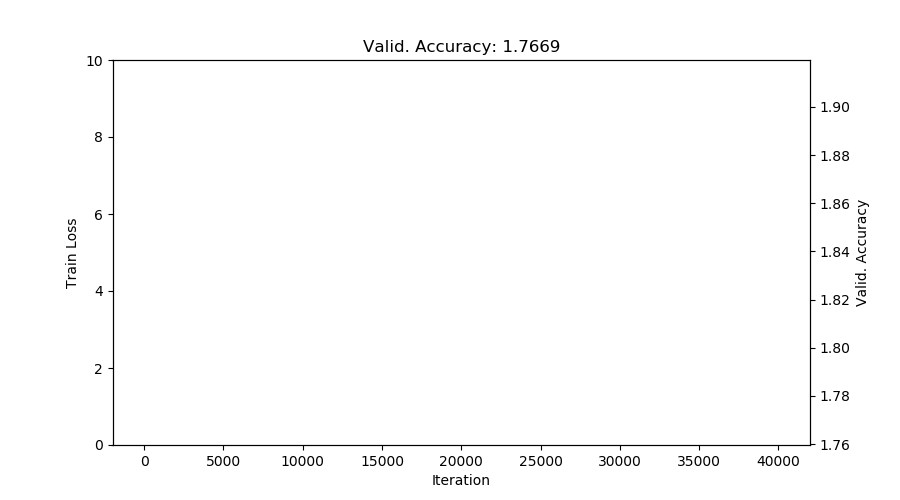

Batch 0 - Loss: 53.302845
    Train Label Err Rate: 1.9406248
    Eval Label Err Rate: 1.6635952



In [ ]:
## Training
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# TesorBoard stats
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Label_err_rate', label_err_rate)
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(summaries_dir + '/train',
                                     sess.graph)
test_writer = tf.summary.FileWriter(summaries_dir + '/test')

# I recommend using tensorboard, comment this out if you want
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        fd = train_iterator.next_feed(BATCH_SIZE)
        sess.run(train_step, feed_dict=fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.update_loss(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            
            accTest = label_err_rate.eval(fd_test)
            accTrain = label_err_rate.eval(fd)
            trainPlot.update_acc(accTest, accTrain, i_batch // TEST_ITER)
            
            testSummary = sess.run(merged, feed_dict=fd_test)
            trainSummary = sess.run(merged, feed_dict=fd)
            test_writer.add_summary(testSummary, i_batch)
            train_writer.add_summary(trainSummary, i_batch)

        if i_batch % SAVE_ITER == 0:
            saver.save(sess, save_loc, global_step=i_batch)
        
        if i_batch % EPOCH == 0:
            fd_test = test_iterator.next_feed(BATCH_SIZE) # BATCH_SIZE)
            print('Batch %r - Loss: %r' % (i_batch, sess.run(loss, fd)))
            print('    Train Label Err Rate: %r' % sess.run(label_err_rate,
                                                            feed_dict=fd))
            print('    Eval Label Err Rate: %r' % sess.run(label_err_rate,
                                                           feed_dict=fd_test))
            print()

except KeyboardInterrupt:
    print('Stopped on batch:', i_batch)
    saver.save(sess, save_loc)
    print('Training interrupted, model saved.')

In [ ]:
for i in range(5):
    fd_test = test_iterator.next_feed(BATCH_SIZE)
    predict_, target_ = sess.run([word_prediction, test_targets], fd_test)
    for i, (inp, pred) in enumerate(zip(target_, predict_)):
        print('    expected  > {}'.format(inp))
        print('    predicted > {}'.format(pred))
        if i >= 1:
            break
    print()